In [4]:
from datasets import load_dataset
emotions = load_dataset("dair-ai/emotion", "split")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
len(train_ds)

16000

In [8]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [9]:
train_ds.column_names

['text', 'label']

In [10]:
print(train_ds.features)

{'text': Value('string'), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}


In [11]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [12]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


In [13]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [14]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


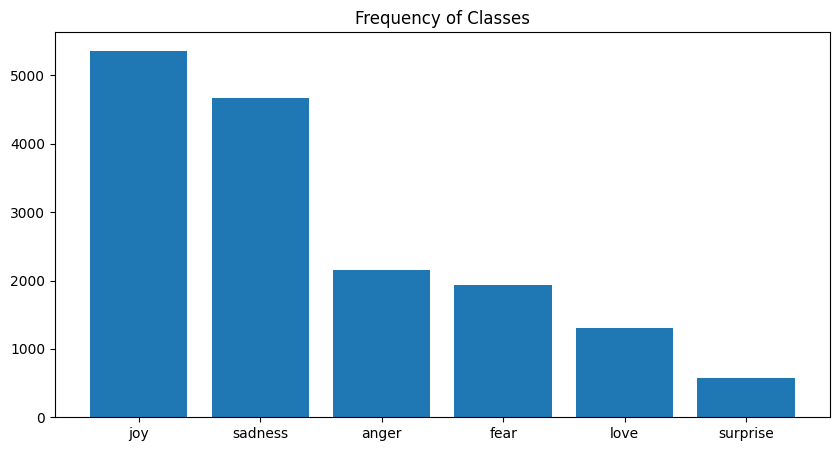

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(df["label_name"].value_counts().index,
        df["label_name"].value_counts().values)
plt.title("Frequency of Classes")
plt.show()

In [16]:
df["label_name"].value_counts()

,count
label_name,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


In [17]:
import seaborn as sns

df['text_length'] = df['text'].str.split().str.len()

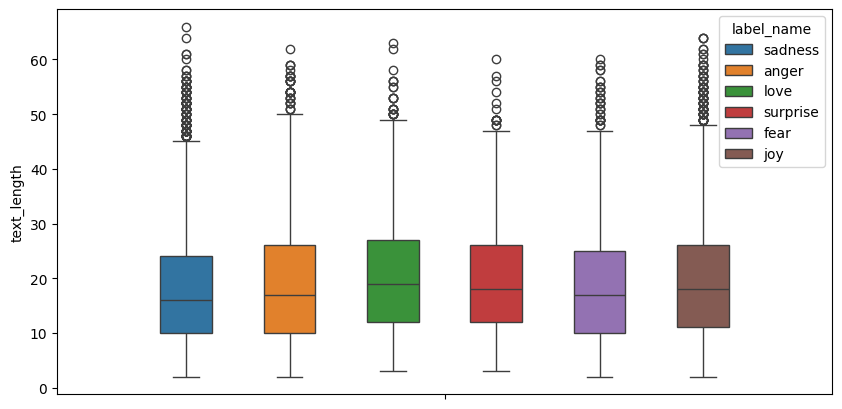

In [18]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y="text_length", hue="label_name", gap=0.5)
plt.show()

In [19]:
emotions.reset_format()

---

In [20]:
# Load tokenizer and model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("distilbert/distilbert-base-uncased")

In [21]:
text = "Apple launched a new phone while I was eating an apple"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 6207, 3390, 1037, 2047, 3042, 2096, 1045, 2001, 5983, 2019, 6207, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [22]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'apple', 'launched', 'a', 'new', 'phone', 'while', 'i', 'was', 'eating', 'an', 'apple', '[SEP]']


In [23]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] apple launched a new phone while i was eating an apple [SEP]


In [24]:
tokenizer.vocab_size

30522

In [25]:
tokenizer.model_max_length

512

In [26]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [27]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [28]:
# Tokenizing the whole dataset
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [29]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


---

In [30]:
# Importing model
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model

DistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0

In [31]:
model.device

device(type='cuda', index=0)

In [32]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [33]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

MaskedLMOutput(loss=None, logits=tensor([[[ -5.9761,  -5.9322,  -5.9373,  ...,  -5.2690,  -5.0063,  -3.1108],
         [-10.4575, -10.4447, -10.4791,  ...,  -9.9761,  -8.5258,  -6.5674],
         [-10.9529, -10.9762, -10.8530,  ...,  -9.6616,  -6.4807,  -7.3477],
         [-13.3985, -13.5582, -13.4019,  ..., -11.2897, -10.2352,  -8.6192],
         [-10.0859, -10.0068, -10.2359,  ...,  -8.5910,  -9.0991,  -4.9456],
         [-10.7658, -10.8063, -10.7302,  ...,  -8.6188,  -8.6334,  -7.4793]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [34]:
outputs[0].shape # [batch_size, n_tokens, hidden_dim]

torch.Size([1, 6, 30522])

In [35]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs)[0]
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [36]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [37]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [38]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [39]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 30522), (2000, 30522))

In [ ]:
# Unresolved
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [55]:
# We increase `max_iter` to guarantee convergence
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=150, max_samples=0.8, max_depth=2, n_jobs=-1)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_samples=0.8, n_estimators=150,
                       n_jobs=-1)

In [56]:
rf_clf.score(X_valid, y_valid)

0.4815

In [57]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

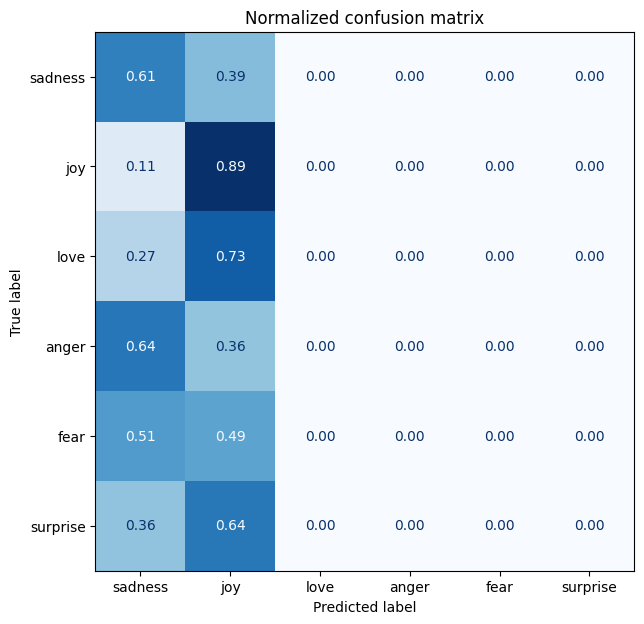

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = rf_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [ ]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained. The next step is to define the metrics that we'll use to evaluate our model's performance during fine-tuning.

#### Defining the performance metrics


To monitor metrics during training, we need to define a `compute_metrics()` function for the `Trainer`.  This function receives an `EvalPrediction` object (which is a named tuple with `predictions` and `label_ids` attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the $F_1$-score and the accuracy of the model as follows:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

With the dataset and metrics ready, we just have two final things to take care of before we define the `Trainer` class:

1. Log in to our account on the Hugging Face Hub. This will allow us to push our fine-tuned model to our account on the Hub and share it with the community.
2. Define all the hyperparameters for the training run.

We'll tackle these steps in the next section.

#### Training the model

If you're running this code in a Jupyter notebook, you can log in to the Hub with the following helper function:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

This will display a widget in which you can enter your username and password, or an access token with write privileges. You can find details on how to create access tokens in the [Hub documentation](https://huggingface.co/docs/hub/security#user-access-tokens). If you're working in the terminal, you can log in by running the following command:

```bash
$ huggingface-cli login
```

To define the training parameters, we use the `TrainingArguments` class. This class stores a lot of information and gives you fine-grained control over the training and evaluation. The most important argument to specify is `output_dir`, which is where all the artifacts from training are stored. Here is an example of `TrainingArguments` in all its glory:

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

Here we also set the batch size, learning rate, and number of epochs, and specify to load the best model at the end of the training run. With this final ingredient, we can instantiate and fine-tune our model with the `Trainer`:

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Looking at the logs, we can see that our model has an $F_1$-score on the validation set of around 92% - this is a significant improvement over the feature-based approach!

We can take a more detailed look at the training metrics by calculating the confusion matrix. To visualize the confusion matrix, we first need to get the predictions on the validation set. The `predict()` method of the `Trainer` class returns several useful objects we can use for evaluation:

In [ ]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

The output of the `predict()` method is a `PredictionOutput` object that contains arrays of `predictions` and `label_ids`, along with the metrics we passed to the trainer. For example, the metrics on the validation set can be accessed as follows:

In [ ]:
preds_output.metrics

It also contains the raw predictions for each class. We can decode the predictions greedily using `np.argmax()`. This yields the predicted labels and has the same format as the labels returned by the Scikit-Learn models in the feature-based approach:

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

With the predictions, we can plot the confusion matrix again:

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

This is much closer to the ideal diagonal confusion matrix.  The `love` category is still often confused with `joy`, which seems natural. `surprise` is also frequently mistaken for `joy`, or confused with `fear`. Overall the performance of the model seems quite good, but before we call it a day, let's dive a little deeper into the types of errors our model is likely to make.

### Sidebar: Fine-Tuning with Keras

If you are using TensorFlow, it's also possible to fine-tune your models using the Keras API. The main difference from the PyTorch API is that there is no `Trainer` class, since Keras models already provide a built-in `fit()` method. To see how this works, let's first load  DistilBERT as a TensorFlow model:

In [ ]:
#hide_output
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels))

Next, we'll convert our datasets into the `tf.data.Dataset` format. Since we have already padded our tokenized inputs, we can do this easily by applying the `to_tf_dataset()` method to `emotions_encoded`:

In [ ]:
# The column names to convert to TensorFlow tensors
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

Here we've also shuffled the training set, and defined the batch size for it and the validation set. The last thing to do is compile and train the model:

In [ ]:
#hide_output
import tensorflow as tf

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

### End sidebar

#### Error analysis

Before moving on, we should investigate our model's predictions a little bit further. A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned. Here's a function that returns the loss along with the predicted label:

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

Using the `map()` method once more, we can apply this function to get the losses for all the samples:

In [ ]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Finally, we create a `DataFrame` with the texts, losses, and predicted/true labels:

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

We can now easily sort `emotions_encoded` by the losses in either ascending or descending order. The goal of this exercise is to detect one of the following:

- _Wrong labels_:: Every process that adds labels to data can be flawed. Annotators can make mistakes or disagree, while labels that are inferred from other features can be wrong. If it was easy to automatically annotate data, then we would not need a model to do it. Thus, it is normal that there are some wrongly labeled examples. With this approach, we can quickly find and correct them.

- _Quirks of the dataset_:: Datasets in the real world are always a bit messy. When working with text, special characters or strings in the inputs can have a big impact on the model's predictions. Inspecting the model's weakest predictions can help identify such features, and cleaning the data or injecting similar examples can make the model more robust.

Let's first have a look at the data samples with the highest losses:

In [ ]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

We can clearly see that the model predicted some of the labels incorrectly. On the other hand, it seems that there are quite a few examples with no clear class, which might be either mislabeled or require a new class altogether. In particular, `joy` seems to be mislabeled several times. With this information we can refine the dataset, which often can lead to as big a performance gain (or more) as having more data or larger models!

When looking at the samples with the lowest losses, we observe that the model seems to be most confident when predicting the `sadness` class. Deep learning models are exceptionally good at finding and exploiting shortcuts to get to a prediction. For this reason, it is also worth investing time into looking at the examples that the model is most confident about, so that we can be confident that the model does not improperly exploit certain features of the text. So, let's also look at the predictions with the smallest loss:

In [ ]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

We now know that the `joy` is sometimes mislabeled and that the model is most confident about predicting the label `sadness`. With this information we can make targeted improvements to our dataset, and also keep an eye on the class the model seems to be very confident about.

The last step before serving the trained model is to save it for later usage. image:images/logo.png[hf,13,13] Transformers allows us to do this in a few steps, which we'll show you in the next section.

#### Saving and sharing the model


The NLP community benefits greatly from sharing pretrained and fine-tuned models, and everybody can share their models with others via the Hugging Face Hub. Any community-generated model can be downloaded from the Hub just like we downloaded the DistilBERT model. With the `Trainer` API, saving and sharing a model is simple:

In [ ]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")

We can also use the fine-tuned model to make predictions on new tweets. Since we've pushed our model to the Hub, we can now use it with the `pipeline()` function, just like we did in <<chapter_introduction>>. First, let's load the pipeline:

In [ ]:
#hide_output
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Then let's test the pipeline with a sample tweet:

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

Finally, we can plot the probability for each class in a bar plot. Clearly, the model estimates that the most likely class is `joy`, which appears to be reasonable given the tweet:

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## Conclusion

Congratulations, you now know how to train a transformer model to classify the emotions in tweets! We have seen two complementary approaches based on features and fine-tuning, and investigated their strengths and weaknesses.

However, this is just the first step in building a real-world application with transformer models, and we have a lot more ground to cover. Here's a list of challenges you're likely to experience in your NLP journey:

My boss wants my model in production yesterday!::
In most applications, your model doesn't just sit somewhere gathering dust - you want to make sure it's serving predictions! When a model is pushed to the Hub, an inference endpoint is automatically created that can be called with HTTP requests. We recommend checking out the [documentation](https://api-inference.huggingface.co/docs/python/html/index.html) of the Inference API if you want to learn more.

My users want faster predictions!::
We've already seen one approach to this problem: using DistilBERT. In <<chapter_compression>> we'll dive into knowledge distillation (the process by which DistilBERT was created), along with other tricks to speed up your transformer models.


Can your model also do X?::
As we've alluded to in this chapter, transformers are extremely versatile. In the rest of the book we will be exploring a range of tasks, like question answering and named entity recognition, all using the same basic architecture.

None of my texts are in English!::
It turns out that transformers also come in a multilingual variety, and we'll use them in <<chapter_ner>> to tackle several languages at once.

I don't have any labels!::
If there is very little labeled data available, fine-tuning may not be an option. In <<chapter_fewlabels>>, we'll explore some techniques to deal with this situation.

Now that we've seen what's involved in training and sharing a transformer, in the next chapter we'll explore implementing our very own transformer model from scratch.